**What I want to do: **First submission gave me a log loss of 0.27459 . This is of course ridiculous, but its ok because the model was trained on the sample data. In the previous steps, I saw using confusion matrix and eyeballing that the sample predicted models were indeed shite. Lets train our model on the full training dataset (1 epoch) and then check our predictions using confusion matrix and eyeballing approaches.

### Admin stuff

In [1]:
%matplotlib inline

#### Define paths for training, test and validation sets

In [2]:
data_dir = "data/data_kaggle_dogscats/"
train_path = "data/data_kaggle_dogscats/train/"
test_path = "data/data_kaggle_dogscats/test/"
validation_path = "data/data_kaggle_dogscats/valid/"
sample_train_path = "data/data_kaggle_dogscats/sample/train/"
sample_validation_path = "data/data_kaggle_dogscats/sample/valid/"
results_path = "data/data_kaggle_dogscats/results/"

In [3]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from datetime import datetime
import re
from keras.preprocessing import image

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Jeremy has created a "utils.py" file with a whole host of convenience utility functions. I need to familiarise this in greater detail, especially the "plots" function. But lets simply use this for now.

In [4]:
import utils; reload(utils)
from utils import plots
from utils import save_array, load_array, plot_confusion_matrix, permutation

In [5]:
# import
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [6]:
# instantiate
vgg = Vgg16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


## Step 15: Load model weights with full training data 1 epoch

In [7]:
# load weights calculated and saved in the previous ipython notebook
vgg.model.load_weights(results_path+"fulltraining.h5")

## Step 16: Test 1 epoch full training set model against validation set to plot confusion matrix

In [8]:
%time val_batches, val_proba = vgg.test(validation_path, batch_size = 64)

Found 5000 images belonging to 2 classes.
CPU times: user 2min 38s, sys: 26.7 s, total: 3min 5s
Wall time: 2min 3s


### Get the true labels, predicted probabilities and then compute predicted labels

In [9]:
filenames = val_batches.filenames
true_labels = val_batches.classes

In [10]:
predicted_proba = val_proba[:,1]
predicted_labels = np.round(predicted_proba)

In [11]:
# check the validity of the predictions using confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels,predicted_labels)
cm

array([[2494,   25],
       [  67, 2414]])

[[2494   25]
 [  67 2414]]


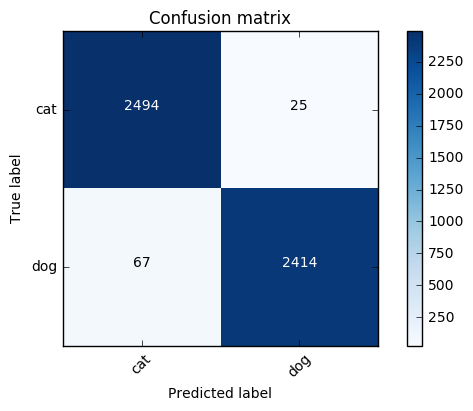

In [12]:
# import plot_confusion_matrix function from utils
plot_confusion_matrix(cm,sorted(val_batches.class_indices))

Contrast this to the sample trained model where false positives (true cat pred dog) were 84 and false negatives were 249.

## Step 17: Eye ball false positives and false negatives to see how badly model is predicting compared to the human eye

In [13]:
# check this by eye-balling the images. USE the PLOTS helper function in utils
def plots_idx(idx, titles=None):
    plots([image.load_img(validation_path+filenames[i]) for i in idx],titles=titles)

### Plot 4 arbitrary (true) dogs that were incorrectly predicted as cats

In [14]:
true_dogs_pred_cats = np.where((true_labels != predicted_labels) & (true_labels == 1))[0]
true_dogs_pred_cats.shape

(67,)

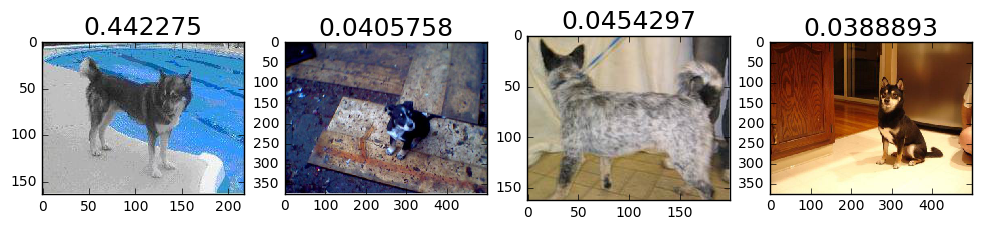

In [15]:
idx = permutation(true_dogs_pred_cats)[:4]
plots_idx(idx,predicted_proba[idx])

### Plot 4 arbitrary (true) cats that were incorrectly predicted as dogs

In [16]:
true_cats_pred_dogs = np.where((true_labels != predicted_labels) & (true_labels == 0))[0]
true_cats_pred_dogs.shape

(25,)

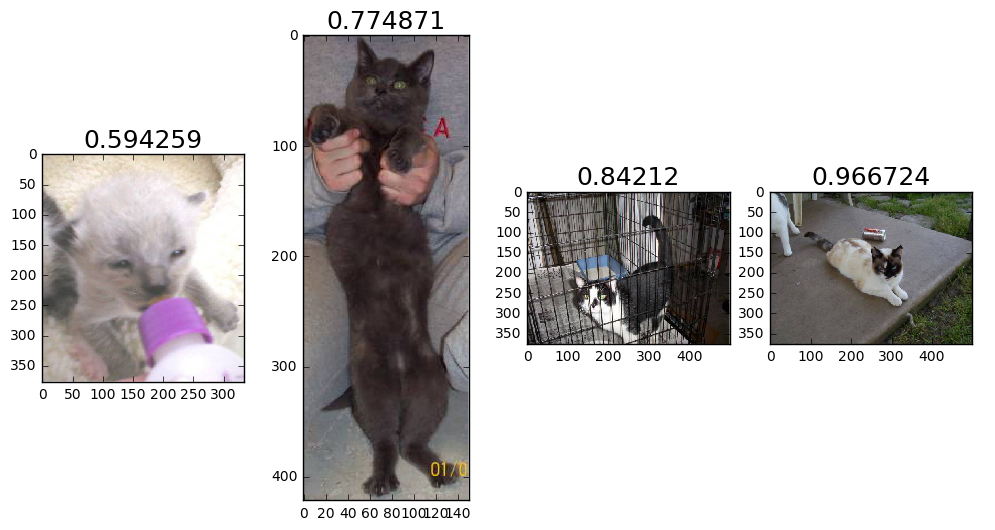

In [17]:
idx = permutation(true_cats_pred_dogs)[:4]
plots_idx(idx,predicted_proba[idx])

TBH, I still dont think the model is doing a fantastic job. Might need some more tuning? But definitely much better than the sample trained model. So expect some massive gains!

## Step 18: Run model against the overall test dataset and submit to Kaggle

In [10]:
# use this to run predictions on the test set
%time batches, predict_proba = vgg.test(test_path)

Found 12500 images belonging to 1 classes.
CPU times: user 6min 28s, sys: 1min 11s, total: 7min 40s
Wall time: 5min 17s


In [12]:
filenames = batches.filenames
save_array(results_path+"test_predictions_fulltraining1epoch.dat", predict_proba)
save_array(results_path+"filenames_fulltraining1epoch.dat", filenames)

Now save the predictions to a new submissions file:

In [13]:
# first load the saved test results
preds = load_array(results_path+"test_predictions_fulltraining1epoch.dat")
filenames = load_array(results_path+"filenames_fulltraining1epoch.dat")
isdog = preds[:,1]
isdog_clipped = np.clip(isdog, 0.05,0.95)
ids = [int(re.findall(r"\d+", i)[0]) for i in filenames]
submission = np.stack([ids,isdog_clipped],axis=1)

In [14]:
%cd $results_path
submission_file_name = 'submission3.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/gitrepo/kaggle_dogs_cats/data/data_kaggle_dogscats/results


This has resulted in a log loss of 0.103, which puts me in the top 30% of the public scores. More tuning is required.